## El caso no separable: Máquinas de Soporte Vectorial

Sigamos discutiendo sobre los clasificadores lineales en el contexto de SVM. Resulta que si
flexibilizamos nuestra función para aceptar que algunas observaciones se sitúen entre los
márgenes, estamos reconociendo que preferimos perder algo de nuestra forma funcional a
cambio de una mayor flexibilidad. En la figura afx.svm_non_separable graficamos el caso
donde permitimos la existencia de observaciones **`dentro`** del margen clasificador. Estos
casos se conocen como slack variables (variables de holgura) en la literatura (Vapnik y
Cortes, 1996 ; Hastie et al. 2009). En la figura se señalan dos casos de slacks:

- ξ < 1: Caso donde la observación se posiciona sobre el margen de su clase, pero bajo el clasificador lineal. Esta es una situación esperable donde el vector tiene una sobreposición menor al margen.

- ξ > 1: Caso donde la observación cruza el clasificador lineal y se posiciona en el margen de la clase contraria. Esta es una situación poco ideal, dado que estamos clasificando de forma errónea la observación.

Resulta que éste último caso sirve como norma para evaluar qué tan bien nuestro modelo
disminuye las clasificaciones erróneas (las observaciones ξ < 1 siguen siendo clasificadas
como azul, sólo que con una menor precisión). Hastie et al. (2009) sugieren que la
optimización del margen debe realizarse considerando ξ > 1.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import warnings
import lec5_graphs as afx
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=(15, 15)
warnings.filterwarnings('ignore')

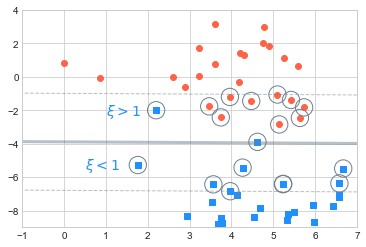

In [2]:
afx.svm_non_separable(plot_slacks=True, plot_xi=True)

Para optimizar la función, consideramos que ξ𝑖 representa la proporción en la que una
predicción $f(x_i) = \beta^T + \beta_0$ se posiciona en el lado equivocado del margen. Mediante esta flexibilización de la norma, estamos generalizando el funcionamiento de SVM. Cabe destacar que hasta el momento la exposición de SVM se ha desarrollado con un caso canónico: una función lineal. En el ejercicio que desarrollaremos a continuación
implementaremos un kernel radial basis function, una de las formas más comunes y
estudiaremos cómo modificar el margen mediante hiper parámetros.

### Clasificando la calidad de vinos
Aplicaremos nuestra primera Máquina de Soporte Vectorial para clasificar la calidad de
vinos dado una serie de atributos fisicoquímicas como la acidez, cantidad de sulfatos,
porcentaje de alcohol. Los datos del ejemplo vienen de P. Cortez, A. Cerdeira, F. Almeida, T.
Matos and J. Reis. Modeling wine preferences by data mining from physicochemical
properties. In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236. Partamos
por exportar nuestros datos, previamente a la inclusión de los módulos correspondientes.



In [3]:
df = pd.read_csv('Datasets/winequality_merged.csv').drop(columns='Unnamed: 0')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Generemos una serie de gráficos, donde visualizaremos las distribuciones si las variables
son float y la frecuencia de ocurrencia si son integer. Observamos que en general los
atributos se presentan en niveles bajos o moderados. En particular, los atributos que
presentan una mayor dispersión en el rango de valores son alcohol, pH y
total.sulfur.dioxide.

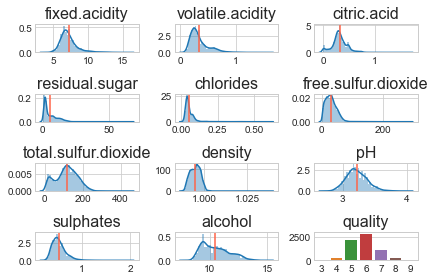

In [4]:
rows = 4
cols = df.shape[1] / rows

for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, int(cols), index + 1)
    if pd.api.types.is_float_dtype(serie) is True:
        sns.distplot(serie)
        plt.axvline(np.mean(serie), color = 'tomato')
    elif pd.api.types.is_integer_dtype(serie) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize = 16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

Para este ejemplo generamos una versión binarizada de la calidad de los vinos. Para ello
vamos a asignar como 1 todas aquellas observaciones cuya calidad sea superior al
promedio, y 0 de lo contrario. Observamos que cerca del 63% de los vinos tuvieron una nota
mas alta que el promedio.

In [5]:
df['quality_bin'] = np.where(df['quality'] > np.mean(df['quality']), 1,0)
df['quality_bin'].value_counts('%').round(3)
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,quality_bin
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Nuestro primer modelo
Para nuestro primer modelo vamos a implementar un kernel lineal, siguiendo el ejemplo
expositivo de arriba. Dado que nuestro objetivo es predecir si la clase de una observación es
0 o 1, implementaremos la clase SVC del módulo svm en la librería sklearn. Como se señaló
arriba, es importante reescalar los datos para evitar la influencia de outliers, para lo cual
importamos la clase StandardScaler. Como en todo flujo de trabajo de modelos de
clasificación, importamos las funciones train_test_split y classification_report.
Finalmente importamos la clase Pipeline del módulo pipeline de la librería sklearn para
poder concatenar pasos de ejecución.

### Digresión: sklearn Pipelines
La clase Pipeline del módulo sklearn.pipeline permite concatenar múltiples pasos de
procesamiento y preprocesamiento en un estimador generado por algún método de
scikit-learn. En sí, la clase cuenta con los métodos clásicos fit, predict y score y
presenta un comportamiento idéntico a los demás objetos de scikit-learn. Uno de los
usos más comunes es para concatenar pasos de preprocesamiento con un modelo.

### Componentes de un Pipeline
Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de
datos, deseo Estandarlizarlo, posteriormente extraer sus principales componentes y
finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:

In [6]:
'''pipeline_model = Pipeline([('scale', StandardScaler()),
                           ('pca', RandomizedPCA(n_components = 3)),
                           ('model', LinearRegression())])'''

"pipeline_model = Pipeline([('scale', StandardScaler()),\n                           ('pca', RandomizedPCA(n_components = 3)),\n                           ('model', LinearRegression())])"

Algunos de los elementos a considerar:

1. Cada paso se considera como una tupla, donde se declara el nombre del paso y la función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que asociamos el método StandardScaler con el string scale.

2. Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso representa el orden de ejecución.

Posteriormente el objeto creado puede utilizarse con los siguientes métodos.

pipeline_model.fit(X_train, y_train)

y_hat = pipeline_model.predict(y_test)

In [7]:
df = df.drop(columns = 'quality')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality_bin
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [8]:
# Generamos las muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'fixed.acidity':'alcohol'], 
                                                    df['quality_bin'], random_state = 15820, test_size = .33)

In [9]:
# Relacion de muestras entre conjunto de entrenamiento y validacion
X_train.shape[0] / df.shape[0]

0.6698476219793751

In [10]:
X_test.shape[0] / df.shape[0]

0.3301523780206249

In [11]:
# Generamos el pipeline
wine_svc = Pipeline([('scaler', StandardScaler()),
                     ('svc', SVC(kernel='linear'))])

Nuestro objeto wine_svc creado con Pipeline nos permite trabajar como si fuese
cualquier otro método de estimación de sklearn, por lo que podemos generar un fit en el
conjunto de entrenamiento, predecir clases con predict utilizando la matriz de atributos de
validación y posterior comparación con clasification_report.

In [12]:
wine_svc.fit(X_train, y_train)
y_hat = wine_svc.predict(X_test)
y_hat[:10]

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1])

In [13]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.57      0.61       747
           1       0.79      0.85      0.82      1398

    accuracy                           0.75      2145
   macro avg       0.73      0.71      0.72      2145
weighted avg       0.75      0.75      0.75      2145



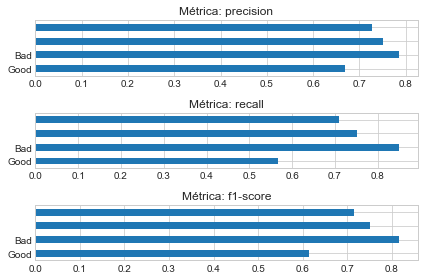

In [14]:
afx.plot_class_report(y_test, y_hat, classes_labels = ['Good','Bad','',''])

A grandes rasgos el modelo tiene un desempeño decente. Obtenemos un 74% de exactitud
en nuestras predicciones (medido con el F1, Recall y Precision). Cuando desagregamos por
clase, los resultados son distintos. El modelo tiene un buen desempeño para identificar
aquellas observaciones que son verdaderamente buenas (etiquetadas con un 1). Respecto a
las observaciones como malas, el clasificador presenta una precisión mucho más alta que
el recall. Esto sugiere que si bien puede reconocer un mal vino a partir de sus componentes,
también falla en reconocer otros vinos que tuvieron un mal ranking en calidad.

### Mejorando nuestro análisis: Kernelización
Hasta el momento hemos trabajado con la versión más "simple" de SVC. Mediante el kernel
lineal establecemos una forma funcional quizás muy estricta que nos esté impidiendo
capturar de mejor manera el fenómeno. Para solucionar esto, haremos uso de una de las
principales características de las Máquinas de Soporte Vectorial: el poder re-expresar
nuestra matriz de atributos en un nuevo espacio que nos permita generar un buen
clasificador. Esto se conoce como el principio de Kernel Lización, a veces referido en la
literatura como Kernel Trick o Kernel-Based Support Vector Machines.

Para este ejemplo, implementaremos la versión más utilizada: el kernel Gaussian radial
basis function. Por motivos prácticos de la lectura lo definiremos de forma explícita dentro
de la clase, siempre recordando que este es el kernel por defecto en SVC de sklearn.

In [15]:
wine_svc_rbf = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])

In [16]:
wine_svc_rbf.fit(X_train, y_train)
y_hat_rbf = wine_svc_rbf.predict(X_test)
y_hat_rbf[:10]

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [17]:
print(classification_report(y_test, y_hat_rbf))

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       747
           1       0.80      0.86      0.83      1398

    accuracy                           0.77      2145
   macro avg       0.75      0.73      0.74      2145
weighted avg       0.77      0.77      0.77      2145



Tan solo con cambiar nuestro kernel, obtenemos un incremento de 2% en el desempeño de
nuestro modelo. De similar manera, las métricas para las clases 0 mejoraron también. Todo
esto parece un tanto mágico, ¿qué es lo que pasa cuando decimos las palabras mágicas
kernel='rbf'?

### ¿Qué es un kernel?
Resulta que cuando nuestro problema no es linealmente separable, necesitamos aplicar una
transformación, llámese κ(𝑥) en nuestra matriz de atributos para re-expresarlos en un nuevo
espacio donde sí sean linealmente separables. Este proceso se conoce como **`kernelización.`**

A grandes rasgos, podemos resumirlo a los siguientes pasos:
- Tenemos una matriz de atributos a reexpresar mediante el aumento de las dimensiones.
- Implementamos alguna función de kernel que nos permita reexpresar las coordenadas mediante similitud de los atributos. De esta manera, implementaremos alguna variante que permita explotar la comunalidad entre los atributos en la medida que aumentamos la cantidad de dimensiones.
- La reexpresión de la matriz kernelizada se puede entender como el reemplazo de todos los productos internos por su versión kernelizada.

![Matriz kernelizada](fotos/kernel_matrix.jpg)

El kernel rbf (Gaussian Radial Basis Function) es una forma de traducir nuestras
observaciones en términos de qué tan similares son entre sí.

Como su nombre lo indica, busca generar una representación "aproximadamente" similar a
la Gaussiana. Para simplificar obtenemos la siguiente visualización:

![Representacion del Kernel](fotos/Representación_kernel.jpg)

En la imagen de la izquierda se muestran las coordenadas de dos atributos, con cada clase
asignada a un color correspondiente. En esta etapa, no existe un clasificador lineal que
pueda separar las clases. El kernel rbf genera una reexpresión de los datos en base a la
similitud de atributos. De esta manera, la forma reexpresada de la matriz facilitará la
clasificación mediante un hiperplano. Las Máquinas de Soporte Vectorial se han beneficiado
de los kernels, aumentando su aplicabilidad en diversos contextos. Dado que los kernels
devuelven una representación de los datos en altas dimensiones mediante el producto
interno de cada observación, son atractivos al hacer que el modelo se desempeñe de forma
eficiente.

Nota: Cabe destacar que un Kernel en el contexto de SVM no es lo mismo que en los métodos
de suavización. Mientras que en éstos últimos hacen referencia a una región específica del
espacio de los atributos donde se obtiene un estimado, para las máquinas de soporte
vectorial un kernel representa una transformación aplicada al producto interno transpuesto de
los atributos.

Los métodos de kernel permiten a las funciones operar en altas dimensiones mediante el
cálculo del producto interno de cada par de datos en el espacio de atributos.
Se pueden comprender como algoritmos de aprendizaje basados en instancias, dado que en
vez de aprender un conjunto fijo de parámetros correspondiente a sus atributos, buscan
recordar un ejemplo de entrenamiento y estimar un peso asociado. El kernel RBF tiene la
siguiente forma funcional: κ(𝑥, 𝑥𝑇) = 𝑒𝑥𝑝(− γ||𝑥 − 𝑥𝑇||2).

Existen otros clásicos kernels que se pueden aplicar:
- Polinomiales de orden-n: κ(𝑥, 𝑥 .𝑇) = (1 + [𝑥, 𝑥𝑇])2
- Sigmoide: κ(𝑥, 𝑥𝑇) = 𝑡𝑎𝑛ℎ(𝑘1||𝑥 − 𝑥𝑇| + 𝑘2)

## Digresión: Métodos de Kernel y Kernel Admisible:
### Métodos de Kernel
Se dice que un método es un método de kernel si se implementa un kernel trick, como vimos
hasta este punto, la SVM es un método de kernel. Los métodos de kernel son atractivos
porque hacen explotar el espacio de atributos facilitando la obtención de espacios
linealmente separables. Aunque lo anterior suena divertido y tentador, como mencionamos
en algún momento en machine learning nos referimos a un fenómeno que ocurre siempre
que tengamos demasiados atributos: La maldición de la dimensionalidad. Uno de los
problemas que esta conlleva es que mientras mayor sea el número de atributos, mayor será
el espacio de búsqueda (aumenta exponencialmente), las SVM funcionan tan bien porque de
cierta forma se blindan de la maldición de la dimensionalidad a través de la maximización
del margen.

### Kernel Admisible
Si bien hemos visto y mencionado un par de kernels básicos muy utilizados, el estudio de
kernels no se limita solo a estos. Podemos definir nuestros propios kernels siempre y
cuando estos cumplan las condiciones de admisibilidad de un kernel (provenientes del
Teorema de Mercer). Una vez que se tiene una función que satisfaga admisibilidad de kernel,
estamos habilitados para mapear nuestro espacio de atributos como queramos.

## Tercera iteración de análisis: Incorporando hiper parámetros
Existen dos hiper parámetros a considerar cuando estamos entrenando modelos SVM:
Costo y γ.

Para visualizar el rango de acción de estos parámetros generaremos un ejemplo sintético
con la puerta XOR, que permite visualizar las virtudes del kernel RBF. Un aspecto a
considerar es que los datos generados en este ejemplo **`no son linealmente separables`**
cuando no implementamos un kernel.


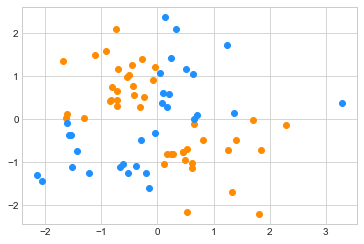

In [18]:
X, y = afx.svm_logical_xor_data(nsize=75)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='darkorange')
plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='dodgerblue')

### Costo
El costo asociado al entrenamiento de un modelo es el hiper parámetro que maneja el
trueque entre penalización de observaciones clasificadas de forma incorrectas y la
estabilización de la función de decisión. La figura generada con svm_c_hyperparameter
visualiza el efecto de C.

Para este ejemplo tomamos 6 valores distintos entre [1, 100000]. A grandes rasgos el
comportamiento de la figura demuestra que cuando los valores de C son pequeños la
función de decisión es mucho más laxa respecto a las clasificaciones erróneas. Lo que logra
en este escenario es acoplarse a la mayoría de los puntos. En la medida que el parámetro
toma valores más altos la función de decisión intenta acoplarse de mejor manera al
conjunto de entrenamiento, conduciendo a overfitting.

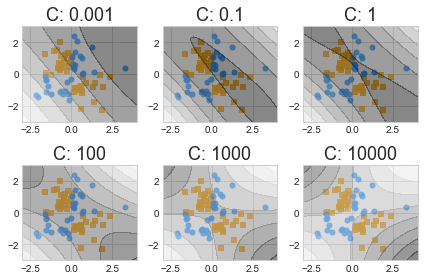

In [19]:
X, y = afx.svm_logical_xor_data(nsize=75)
afx.svm_c_hyperparameter(X, y, c_range=[0.001, 0.1, 1, 100, 1000,10000])

### Gamma
γ es el parámetro que controla el ancho del kernel cuando es rbf. ¿En qué afecta esto?
controla la influencia de un punto en específico en la función de decisión. La figura creada
con afx.svm_gamma_hyperparameter evalúa el hiper parámetro en 6 puntos distintos.

Cuando γ tiene valores bajos, el kernel RBF tiene un área mayor, impidiendo que el modelo
detecte bien cómo varían los puntos. En este escenario el modelo asume que todos los
puntos se consideran semejantes entre sí, ignorando las clases. En la medida que γ
aumenta de valor, el kernel RBF tendrá una mayor sensibilidad a las clases en el conjunto de
entrenamiento. De similar manera a los altos valores de C, valores altos en γ pueden
conducir a overfitting.

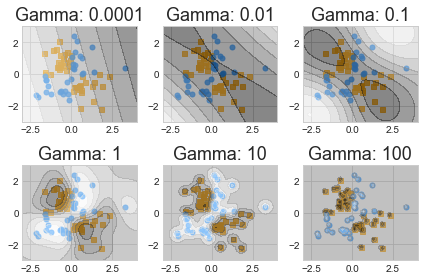

In [20]:
afx.svm_gamma_hyperparameter(X, y, gamma_range=[0.0001, 0.01,0.1, 1, 10, 100])

### ¿Cómo encontramos la mejor combinación de hiper parámetros?

Los modelos SVM necesitan de ambos hiper parámetros mencionados para funcionar
adecuadamente. Dado que el costo de la función de decisión está asociado fuertemente
con el radio del kernel γ.
Si imponemos mayores niveles en γ necesitaremos que nuestra función de decisión sea
menos tolerante con las clasificaciones erróneas, por lo que implementamos C con bajos
parámetros.

Lamentablemente no existen hiper parámetros recomendados por defecto para éstos
modelos, por lo que debemos realizar una búsqueda cruzada entre ambos para encontrar un
mejor desempeño del modelo. Esta búsqueda cruzada se conoce como búsqueda de grilla.
Hsu et al (2016) recomiendan implementar una búsqueda de grilla donde cada combinación
de hiper parámetros se evalúa mediante validación cruzada. Este procedimiento resulta ser
computacionalmente demandante, dado que la cantidad de modelos a estimar es
𝐶 × γ × 𝐶𝑉.

Se recomienda partir con un rango amplio de hiper parámetros a evaluar, para reflejar el
efecto de un modelo laxo. Siguiendo los consejos de Hsu et al. (2016), se recomiendan
rangos 𝐶 ∈ {2 y .−5,..., 215} γ ∈ {2−15,..., 23}

### Implementación manual de la búsqueda de grilla con validación cruzada
Antes de detallar el procedimiento, cabe destacar que sklearn presenta una
implementación en el módulo model_selection llamada GridSearchCV que replica el
mismo proceso. Por motivos expositivos, preferimos detallar el procedimiento de manera
explícita, evitando esconder esto en una caja negra. Los pasos para implementar el
algoritmo son:
1. Estandarizar los datos con StandardScaler o algún otro procesador como Normalizer o MinMaxScaler.
2. Generar conjuntos de entrenamiento y validación con train_test_split y preservar la muestra de validación.
3. Generamos un loop anidado entre 𝐶 y γ.
4. Dentro de la anidación, implementamos una validación cruzada del desempeño utilizando cross_val_score en la muestra de entrenamiento. Se sugiere manejar el rango de validaciones entre 5 y 10.
5. La validación cruzada generará una lista con los puntajes para cada iteración. Éstos se preservan en un objeto para posterior uso.
![Valisdacion Cruzada](fotos/Validacion_Cruzada.jpg)

Hay un par de elementos a considerar en este procedimiento, para lo cual nos apoyaremos
en esta imágen. En primer lugar, evitamos realizar la validación cruzada en la muestra
completa para no entrenar el modelo con datos que ya tiene conocimiento. Eso es el
equivalente a desarrollar una partición en tres, donde tendremos muestras de entrenamiento
y validación a iterar (que emergen de nuestro conjunto de entrenamiento). En base a la
mejor combinación de hiper parámetros, predecimos los valores frente a los datos de
validación **`no incorporados en la validación cruzada`**. En algunas partes esta se conoce
como un held-out sample.

En segundo lugar, cabe destacar que ésta solución no es definitiva. Posteriormente hay que
evaluar si el desempeño del modelo es variante, condicional al rango de hiper parámetros.
Murphy (2012) entre otros, sugiere que si el desempeño no varía con los hiper parámetros,
se puede reasignar el rango hasta que se presente variabilidad en el desempeño.

In [21]:
# Estandarizamos la matriz de atributos
X_scaled = StandardScaler().fit_transform(df.loc[:,'fixed.acidity':'alcohol'])
# Generamos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['quality_bin'], random_state = 15820, test_size = .33)

In [22]:
# rango de C
c_param_range = [1, 10, 100, 1000, 10000, 100000]
# rango de Gamma
gamma_param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
# generamos un diccionario vacío para guardar la combinación
# de hiperparámetros y su desempeño asociado
empty_dict = {}
# capturamos el mejor puntaje
best_score = 0
# iniciamos una lista para capturar la iteración del 1er
# hiperparametro
c_holder = []
# para cada valor en el primer rango
for c in c_param_range:
    # iniciamos una lista para capturar la iteración del
    # 2do parámetro
    gamma_holder = []
    # para cada valor en el segundo rango
    for gamma in gamma_param_range:
        tmp_score = cross_val_score(SVC(C = c, gamma = gamma), X_train, y_train, cv = 5, n_jobs = -1)
        # validamos de forma cruzada con el conjunto de entrenamiento!
        empty_dict[str("C: {}, Gamma: {}".format(c, gamma))] = list(tmp_score)
        # Agregamos a cada lista secundaria el promedio de validación cruzada
        gamma_holder.append(np.mean(tmp_score))
        # si la media es mejor que el mejor puntaje registrado
        if np.mean(tmp_score) > best_score:
            best_score = np.mean(tmp_score)
            # extraemos el string asociado a la combinación de valores
            best_params = str("C: {}, Gamma: {}".format(c, gamma))
    # adjuntamos la lista secundaria de cada valor a la primaria.
    c_holder.append(gamma_holder)
# redimensionamos a una matriz
cv_params = np.array(c_holder).reshape(6, 6)

In [23]:
cv_params

array([[0.6238513 , 0.6238513 , 0.71713739, 0.75114665, 0.76746163,
        0.76883936],
       [0.6238513 , 0.71782652, 0.7440218 , 0.75689061, 0.77665123,
        0.77251778],
       [0.71782652, 0.74080658, 0.74953772, 0.7596458 , 0.7649321 ,
        0.77159956],
       [0.73919765, 0.74448236, 0.75367249, 0.7635549 , 0.75321536,
        0.77159956],
       [0.74080631, 0.7481592 , 0.75711865, 0.76493237, 0.74792642,
        0.77159956],
       [0.74310358, 0.75068556, 0.75734906, 0.76906713, 0.74218246,
        0.77159956]])

In [24]:
best_score

0.7766512266254931

In [25]:
best_params

'C: 10, Gamma: 0.1'

Para visualizar los resultados generamos dos gráficos. La figura de la izquierda presenta los
diagramas de caja para cada una de las validaciones. Éste entrega información sobre qué
tanto varía el desempeño en cada una de las iteraciones de la validación cruzada. La figura
de la derecha presenta un heatmap con el promedio del desempeño en las cinco iteraciones.

Text(0.5, 1.0, 'Accuracy Heatmap')

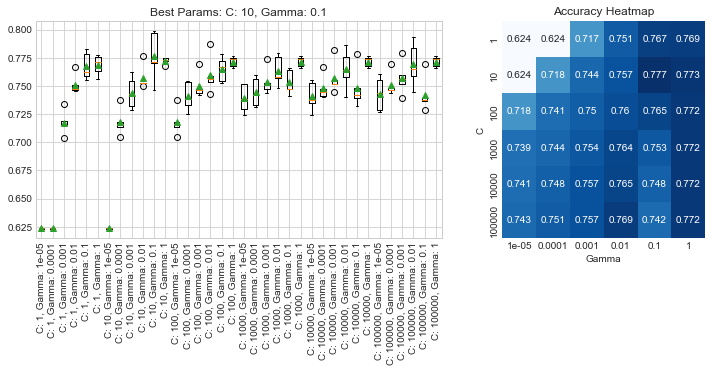

In [26]:
plt.figure(figsize=(12, 4))
# Fijamos tamaños personalizados en el canvas
grid = GridSpec(1, 2, width_ratios=[2,1])
# con el primer espacio del canvas
plt.subplot(grid[0])
# generamos diagramas de caja para cada validación cruzada
# y solicitamos la media
plt.boxplot(empty_dict.values(), showmeans=True);
plt.xticks(range(1, len(empty_dict.keys()) + 1), empty_dict.keys(),
rotation=90);
plt.title("Best Params: {}".format(best_params));
# para el segundo espacio del canvas
plt.subplot(grid[1])
# visualizamos el desempeño promedio de cada combinación.
sns.heatmap(cv_params, annot=True, cmap='Blues', cbar=False, xticklabels=gamma_param_range,
yticklabels=c_param_range, fmt=".3")
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap')

Comencemos por inspeccionar la figura de los gráficos de caja. Absolutamente todos los
clasificadores entrenados presentan un desempeño mejor que un clasificador aleatorio (en
este caso 1/2=.5). Cada uno de los gráficos de caja muestra cuál fue la distribución
empírica de la exactitud. El título nos informa que la mejor combinación es cuando
𝐶 = 10, γ = 0. 1.

El heatmap señala que en el caso, la exactitud es del .771.

### Cuarta iteración: entrenamiento del modelo con los mejores hiper parámetros
Un aspecto a considerar es el hecho que estamos implementando una búsqueda de grilla en
un conjunto de entrenamiento, separando una muestra de **`no incorporados en la validación cruzada`** Resulta que
mediante esta división trietápica de los datos logramos simular de una mejor manera cómo
se desempeñaría el modelo en un conjunto de datos anteriormente no vistos. De no hacerlo,
podemos incurrir en dos tipos de sobre ajuste: Un sobreajuste dado a la **`optimización de los hiper parámetros`** en la grilla, y otro sobreajuste dado el **`proceso de aprendizaje en los mismos datos que posteriormente serán evaluados mediante el modelo.`**

![Evaluación de datos excluidos de la Calibración y el entrenamiento](fotos/Eval_data.jpg)

Los gráficos sugieren que el mejor desempeño de modelo se logra con la combinación de
hiper parámetros 𝐶 = 10, γ = 0. 1.

Con esta información a mano, ponemos a prueba nuestro clasificador contrastando los
puntajes predichos **`con la muestra de validación que dejamos fuera del procedimiento`**. Si
bien el procedimiento entregó una tasa de exactitud de .771, su desempeño en la muestra
de validación fue de .78.


In [27]:
refactor_svc_rbf = Pipeline([('scaler', StandardScaler()),
                             ('svc', SVC(kernel = 'rbf', C = 10, gamma = 0.1))])

In [28]:
refactor_svc_rbf.fit(X_train, y_train)
yhat_svc_rbf = refactor_svc_rbf.predict(X_test)

In [29]:
print(classification_report(y_test, yhat_svc_rbf))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       747
           1       0.82      0.86      0.84      1398

    accuracy                           0.79      2145
   macro avg       0.77      0.76      0.76      2145
weighted avg       0.79      0.79      0.79      2145



## Consideraciones
Para cerrar esta lectura, presentamos una serie de aspectos adicionales que se pueden considerar.
### Problemas donde: γ ≥ 2
Originalmente las máquinas de soporte vectorial fueron diseñadas para generar
clasificaciones en casos binarios. Hsu y Lin (2002) consideran que para extenderlas en más
clases es un área que todavía está en desarrollo. A grandes rasgos, las clasificaciones
multiclases con SVM se basan mediante la combinación de múltiples sub clasificadores
posibles:
- One-against-all: Bajo esta estrategia se generan tantos subclasificados como clases existentes en el vector objetivo. En base a cada sub clasificador se extrae una función de decisión y posteriormente se elige aquella que maximice el valor.
- One-against-one: Bajo esta estrategia se generan 𝑘(𝑘 − 1)/2 sub clasificadores, donde k es la cantidad de clases en el vector objetivo. En base a cada sub clasificador, se implementa una estrategia de votación simple para cada una de las observaciones.

Ambas estrategias se implementan en SVC al modificar la opción
decision_function_shape. Por defecto la opción es **`'ovr'`** que corresponde a la
estrategia one-against-all. Para implementar la estrategia one-against-one con la opción
**`'ovr'`**. Dado que una de las principales limitantes es el hecho que si nuestro vector objetivo
tiene un alto número de categorías (dígase 10), el tiempo de ejecución del algoritmo puede
ser prohibitivo.

### SVM en regresión
Las Máquinas de Soporte Vectorial también se pueden implementar para problemas de
regresión. Para este tipo de tarea buscamos predecir un valor real de y de forma tal que para
toda observación 𝑥𝑖 tengamos un 𝑦𝑖 correspondiente. El algoritmo busca un y que minimice 
una función de error candidata. De similar manera, buscamos desarrollar un margen dado
por ε. Este modelo se conoce como regresión ε − 𝑖𝑛𝑠𝑒𝑛𝑠𝑖𝑏𝑙𝑒.

Esto genera una regresión robusta frente a los residuales. Berk (2008) señala que hasta el
momento no hay una ventaja comparativa clara entre la regresión ε − 𝑖𝑛𝑠𝑒𝑛𝑠𝑖𝑏𝑙𝑒 y otras
formas de regresión robusta.

#### Puntos a favor
- Son efectivas en espacios de altas dimensiones.
- Son relativamente eficientes cuando la cantidad de dimensiones es mayor a la cantidad de observaciones.
- Es eficiente en términos de memoria porque utiliza un subconjunto de datos de entrenamiento para generar la función de decisión.
#### Puntos en contra
- SVM no se pensó en capturar la función generadora en los atributos, por lo que es
  difícil identificar el impacto de los atributos en nuestro vector objetivo. SVM
  pertenecen a un grupo de algoritmos conocidos como modelos de caja negra, dado
  que no entregan mucha información sobre cómo se llega a cierto resultado. Esto en
  oposición a los métodos basados en regresión.

### Referencias
- Berk, Richard A. 2008. Statistical learning from a regression perspective. Vol. 14. New
  York: Springer.
- Cortes, C; Vapnik, V. 1995. Support-Vector Networks. Machine Learning 20. pp:
  273-297.
- Hastie, T; Tibshirani, T; Friedman, J. 2008. The Elements of Statistical Learning: Data
  Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch12:
  Support Vector Machines and Flexible Discriminants.
- Hsu, Chih-Wei, and Chih-Jen Lin. 2002. A comparison of methods for multiclass
  support vector machines. IEEE transactions on Neural Networks 13, no. 2: 415-425.
- Hsu, Chih-Wei, Chih-Chung Chang, and Chih-Jen Lin. 2016. A practical guide to
  support vector classification. 1-16.
- Murphy. K. 2012. Machine Learning. A Probabilistic Perspective, Cambridge, MA:
  Massachusetts Institute of Technology Press. Ch14: Kernels. 14.4: The Kernel Trick.
  14.5: Support Vector Machines.